In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths


import sys, os
sys.path.append(os.path.abspath('../..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

# plt.rcParams['lines.linewidth'] = 0.5 



In [51]:

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [173]:
exchange = 'kucoin'
pair = 'ETH_USDT'
timeframe = '1d'

odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

# odf['idate'] = odf.dtime.dt.strftime('%Y%m%d')
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)

odf.shape, odf.head(5)

((1283, 6),
                 timestamp    open    high     low   close        volume
 dtime                                                                  
 2020-01-01  1577836800000  129.22  132.96  128.77  130.68   9096.221067
 2020-01-02  1577923200000  130.70  130.76  126.42  127.12  13948.826889
 2020-01-03  1578009600000  127.14  135.00  125.95  134.32  22306.405437
 2020-01-04  1578096000000  134.32  135.76  132.58  134.23  10255.001137
 2020-01-05  1578182400000  134.23  138.12  134.21  135.38  15608.143145)

In [210]:
df = odf[['open','high','low','close']].copy()
# Predictor variables
# df['Open-Close']= df.Open -df.Close
# hsample = '3D'
# h_columns = ['open', 'high', 'low', 'close']
# df = odf[h_columns].resample(hsample).agg(
#     OrderedDict([
#         ('open', 'first'),
#         ('high', 'max'),
#         ('low', 'min'),
#         ('close', 'last'),
#     ])
# )

lags = [i for i in [1,3,7,14, 30, 60, 120] ]
lag_columns = [f'lret_{n}' for n in lags]

def add_indicators(df):
    df['high-low']  = df.high - df.low
    df['lret'] = (df['close']/df['close'].shift(1)).apply(np.log)

    df = df.dropna()
    for i in range(len(lags)): 
        df[lag_columns[i]] = df.close.divide(df.close.shift(lags[i])).apply(np.log)

    df = df.dropna()
    return df

df = add_indicators(df.copy())
X = df[['high-low'] + lag_columns]
X.head()

,high-low,lret_1,lret_3,lret_7,lret_14,lret_30,lret_60,lret_120
dtime,,,,,,,,
2020-05-01,11.02,0.028120,0.077531,0.122557,0.217313,0.446865,-0.089523,0.511738
2020-05-02,5.00,0.008686,-0.006802,0.096564,0.132310,0.413963,-0.045465,0.465330
2020-05-03,14.04,-0.019305,0.017500,0.060714,0.153182,0.394799,-0.066779,0.446695
2020-05-04,15.76,-0.015417,-0.026036,0.050832,0.192802,0.360117,-0.100178,0.422747
2020-05-05,10.35,-0.006312,-0.041034,0.045183,0.184555,0.364267,-0.176615,0.353875


In [211]:
# Target variable
y = np.where(df['close'].shift(-1)>df['close'],1,-1)

In [212]:
# Splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [213]:
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.63
Test_data Accuracy: 0.51


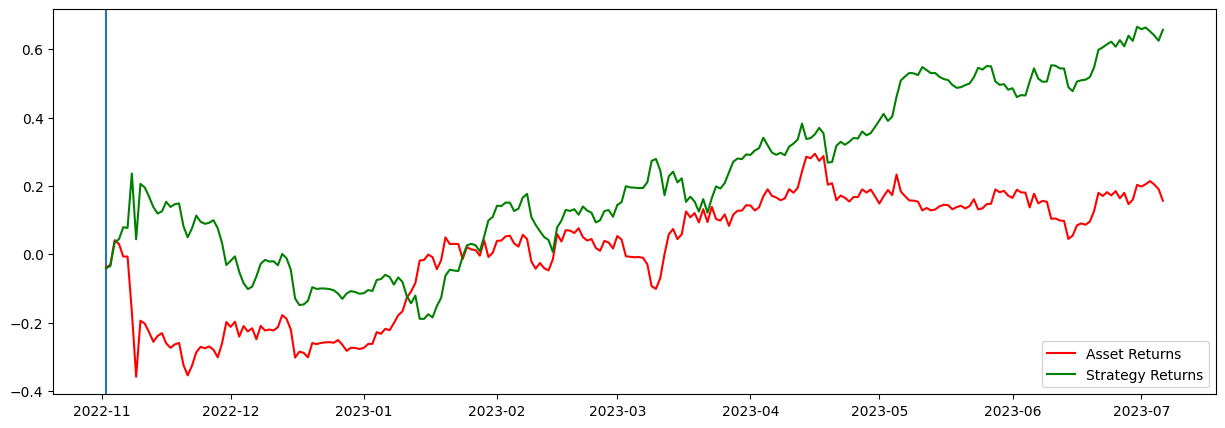

In [214]:
# Predicted Signal
df['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
Cumulative_Asset_returns = df[X_test.index[0]:]['lret'].cumsum()

# Cumulative Strategy Returns 
df['Startegy_returns'] = df['lret']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[X_test.index[0]:]['Startegy_returns'].subtract(0.002).cumsum()

# Plot the results to visualize the performance

plt.figure(figsize=(15,5))
plt.axvline(X_test.index[0])
plt.plot(Cumulative_Asset_returns, color='r',label = 'Asset Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [222]:
exchange = 'kucoin'
pair = 'LTC_USDT'
timeframe = '1d'

adf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

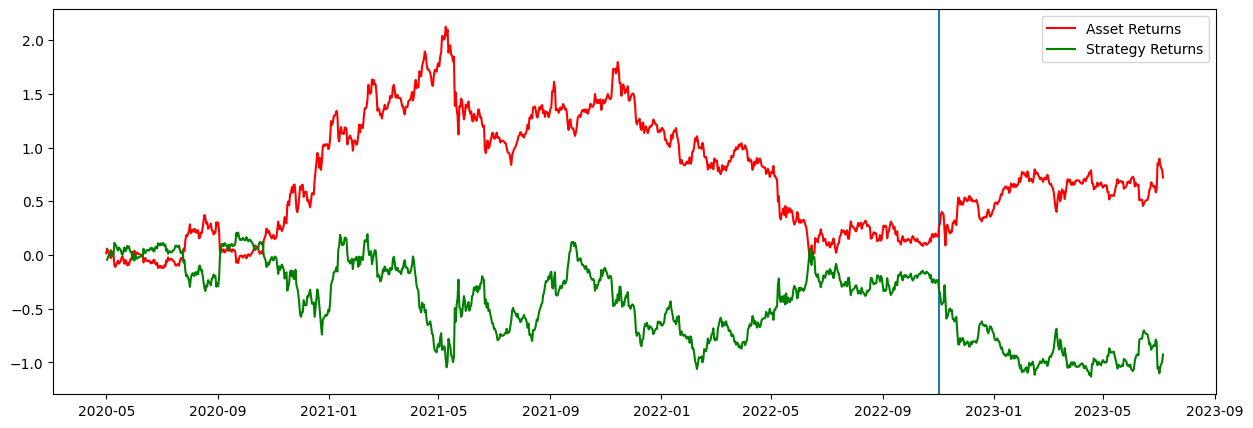

In [223]:

df = add_indicators(adf.copy())

X = df[['high-low'] + lag_columns]

# Predicted Signal
df['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
Cumulative_Asset_returns = df[:]['lret'].cumsum()

# Cumulative Strategy Returns 
df['Startegy_returns'] = df['lret']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[:]['Startegy_returns'].subtract(0.00).cumsum()

# Plot the results to visualize the performance

plt.figure(figsize=(15,5))
plt.axvline(X_test.index[0])
plt.plot(Cumulative_Asset_returns, color='r',label = 'Asset Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()